In [1]:
# imports
library(tidyverse)
library(tidymodels)
library(GGally)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Introduction:

### Relevant Background Information:
This project aims to answer a predictive question about a dataset using concepts such as data description, exploration, visualisation, and analysis. The dataset to be used, ‘players.csv’, is collected from a Minecraft Server set up to record player statistics. The dataset contains data of each individual players’ actions and information. In order to recruit more players to the game, it is important to know what characteristics of players are most likely to contribute to a large amount of data, or more hours played. Specifically, the project aims to examine to what extent does player experience level predict number of hours played, and does that vary with age?   
### Investigative Questions: Will be using players.csv exclusively
- Broad: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.
- Specific: To what extent does player experience predict played_hours, and does that vary with age?
- How the data will help address this question:
    - We can look at the effects of using only age or experience as a predictor for played_hours, then look at how that differs from using both as predictors simultaneously. Intuitively speaking, the more experience you have, the less you need to play (until you reach a competitive threshold). The less experience you have, the more you need to play. And vice versa. Finally, age determines how much time you can dedicate to Minecraft.
- Data wrangling plans:
    - In terms of wrangling, players.csv looks generally. All the players' information is contained within a row, each cell measures one thing, and each column represents one distinct variable. That being said, the age variable contains 2 NAs, so imputation will be required, and for our regression model, encoding of the categorical variables will be needed.
- Evaluation plans:
    - Seeing as the data does not exhibit a linear relationship, and has some extreme outliers, we will be using knn regression to predict played_hours. In terms of our evaluation metric of choice, we will be using RMSE. The reason for RMSE is due to the fact that there a lots of small values, and quite a few extreme outliers. So, using the square root, we should be able to tighten up the values, so that magnitude does not play much of a role in error.
      
### Data Description: players.csv
- Number of observations: 196
- Summary Statistics:
    - played_hours:
        - Min: 0.00
        - Median: 0.10
        - Mean: 5.85
        - Max: 223.10
    - Age:
        - Min: 9.00
        - Median: 19.00
        - Mean: 21.14
        - Max: 58.00
    - subscribe:
        - FALSE: 52
        - TRUE: 144
- Number of variables: 7
    - experience: Categorical/Ordinal
        - How much experience a player has playing Minecraft
    - subscribe: Categorical/Binary 
        - Whether or not a player is subscribed to a game-related newsletter
    - hashedEmail: Categorical
        - A player's email, hashed/encrypted for privacy
    - played_hours: Numerical
        - How many hours a player played on the PlaiCraft server
    - name: Categorical
        - A player's name
    - gender: Categorical
        - A player's gender
    - Age: Numerical
        - The age of a player
- Issues in the data:
    - Age variable contains 2 NAs, will require imputation
    - Imbalanced, and a poor spread of data (e.g. a lot of players have played_hours = 0)
    - Very small sample size, so results may be skewed, especially with models that are easily influenced by extreme values
- Irrelevant variables:
    - name, hashedEmail
        - This is arbitrary and does not predict how much data one might contribute

In [2]:
player_data <- read_csv("https://raw.githubusercontent.com/Andrewhli06/dsci100-project/refs/heads/main/players.csv")
summary(player_data)
head(player_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


  experience        subscribe       hashedEmail         played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               Age       
 Length:196         Length:196         Min.   : 9.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :21.14  
                                       3rd Qu.:22.75  
                                       Max.   :58.00  
                               

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


## Methods and Results:

### Wrangling:

In [3]:
# Selecting only the columns that are relevant to our question (Age, experience, played_hours)
# Filtering out the extreme outliers due to the nature of the dataset (mostly under 50 played hours, so our predictions would be heavily error prone/uninsightful with those 5-10 outliers)
# Ideally, the dataset would have a lot less 0s (a baseline that predicts 0 would likely out perform all models), and we would filter for <= 20, but we want to preserve some of the outlier nature of the dataset.
columns <- player_data |> 
           select(Age, experience, played_hours) |>
           filter(played_hours <= 50)
player_predictors <- as_tibble(columns)
player_predictors$experience <- factor(player_predictors$experience,
                                       levels = c("Amateur", "Beginner", "Regular", "Veteran", "Pro"),
                                       ordered = TRUE)
player_predictors <- player_predictors |> 
                     mutate(experience_int = as.numeric(experience))
head(player_predictors)

Age,experience,played_hours,experience_int
<dbl>,<ord>,<dbl>,<dbl>
9,Pro,30.3,5
17,Veteran,3.8,4
17,Veteran,0.0,4
21,Amateur,0.7,1
21,Regular,0.1,3
17,Amateur,0.0,1


In [4]:
# 85/190 rows are made up of 0s !!!
counts <- player_predictors |> count(played_hours)
head(counts)
nrow(player_predictors)

played_hours,n
<dbl>,<int>
0.0,85
0.1,34
0.2,10
0.3,5
0.4,5
0.5,4


[1] 190

In [5]:
set.seed(42)
# Spliting the data with a 70/30 split
player_split <- initial_split(player_predictors, prop = 0.7, strata = played_hours)
player_training <- training(player_split)
player_testing <- testing(player_split)

# Transforming the data appropriately (i.e. imputation on the NA values in the dataset, did not fit on the test set so no data leakage)
preprocess_recipe <- recipe(played_hours ~., data = player_training) |>
                     step_impute_mean(all_numeric_predictors())
prep_recipe <- prep(preprocess_recipe)
train_processed <- bake(prep_recipe, new_data = player_training)
test_processed <- bake(prep_recipe, new_data = player_testing)

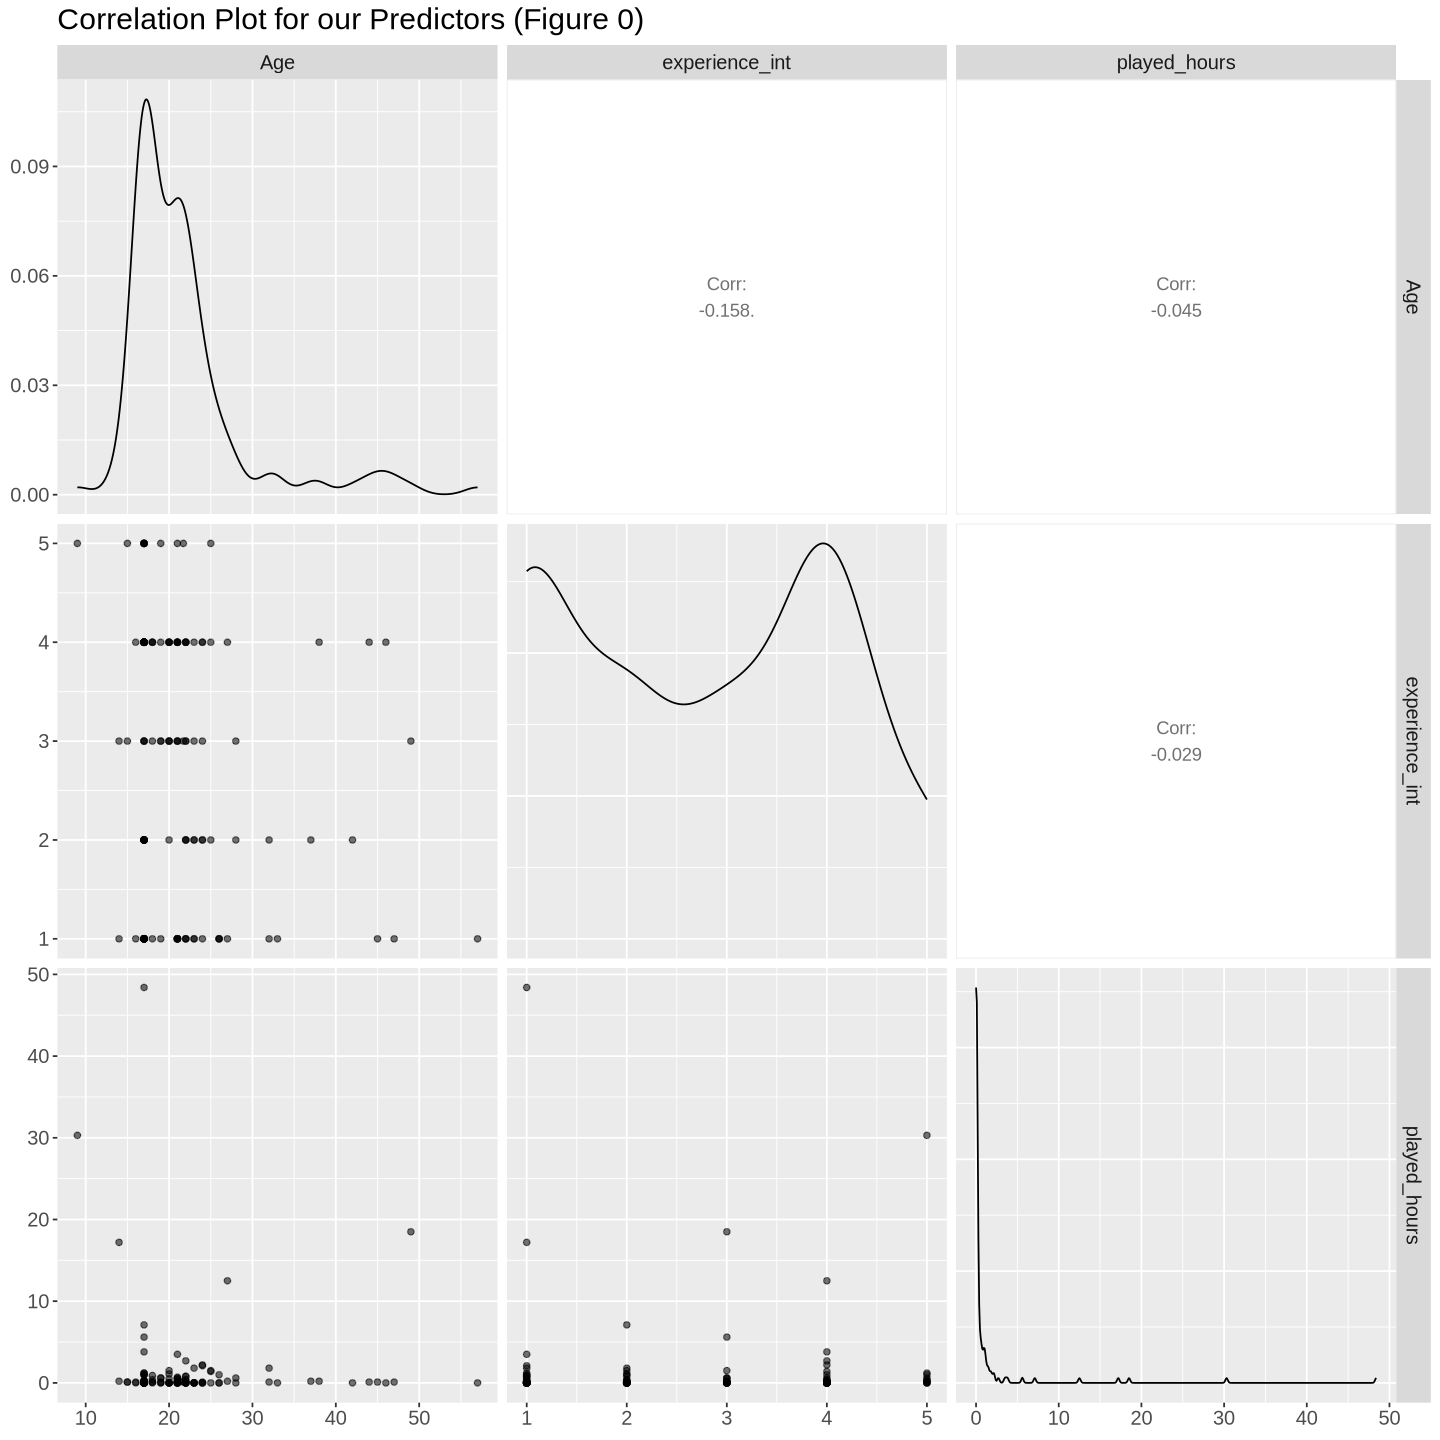

In [6]:
options(repr.plot.width = 12, repr.plot.height = 12)
player_pairplot <- train_processed |> 
                   select(-experience)|>
                   ggpairs(mapping = aes(alpha = 0.4)) +
                   theme(text = element_text(size = 15)) +
                   ggtitle("Correlation Plot for our Predictors (Figure 0)")

# your code here
player_pairplot

#### Interpretation of Figure 0

Our correlation plot shows us several things. Firstly, we see that player ages lie almost entirely within the range of 10-30 years; that player experience peaks at two levels, either complete beginner or veteran; and that playtime has one peak at zero (0) hours played which drops quickly. Secondly, we see minimal obvious correlation between playtime and age (most playtime occurred among players in our 10-30 years old peak) or between playtime and experience (most players of any given experience level played very few hours).

### EDA:

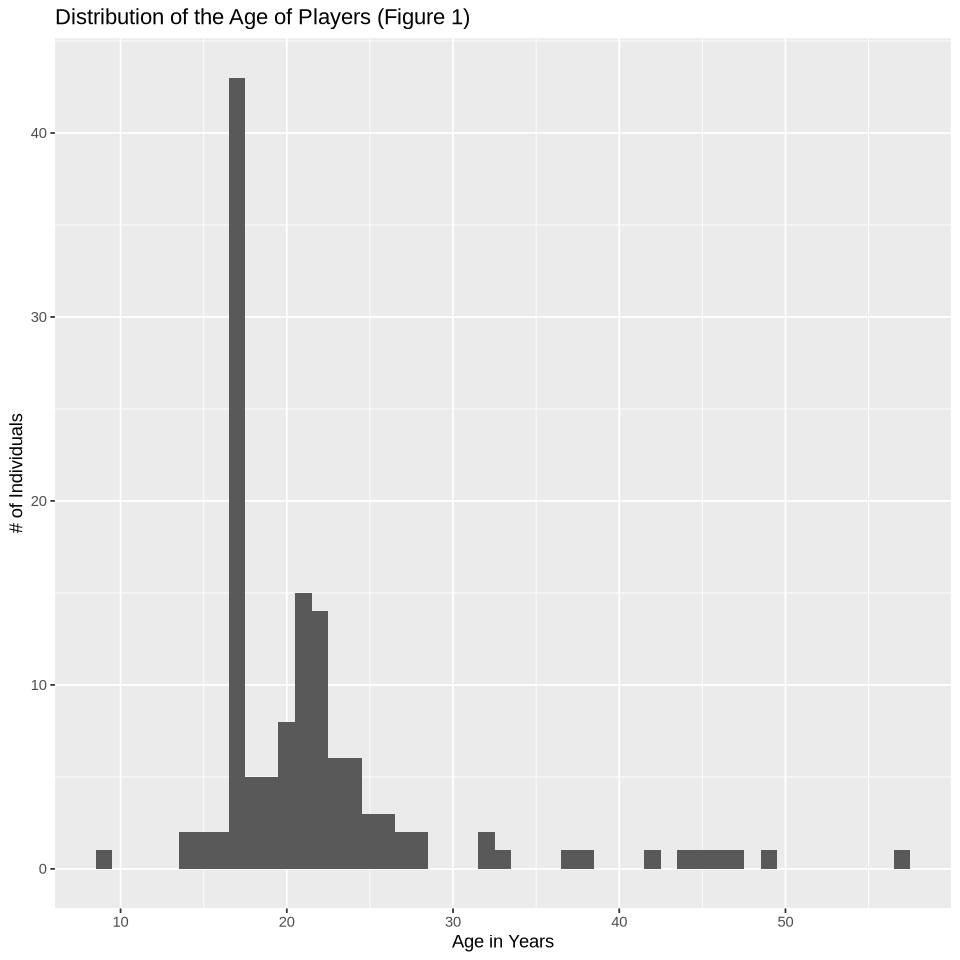

In [7]:
options(repr.plot.width = 8, repr.plot.height = 8)
age_hist <- train_processed |>
            ggplot(aes(x = Age)) +
            geom_histogram(binwidth = 1) +
            labs(title = "Distribution of the Age of Players (Figure 1)",
                 x = "Age in Years",
                 y = "# of Individuals")
age_hist

#### Interpretation of Figure 1
 Figure 1 illustrates the age distribution of players in the dataset. The vast majority of users are between 16 and 28 years old, indicating that the server is primarily used by young adults. Players under 12 and those over 30 are extremely rare, suggesting limited engagement in these age groups. The age distribution exhibits right skewness with a long tail in the older age brackets, indicating that while some older individuals exist in the sample, they represent a small proportion. 

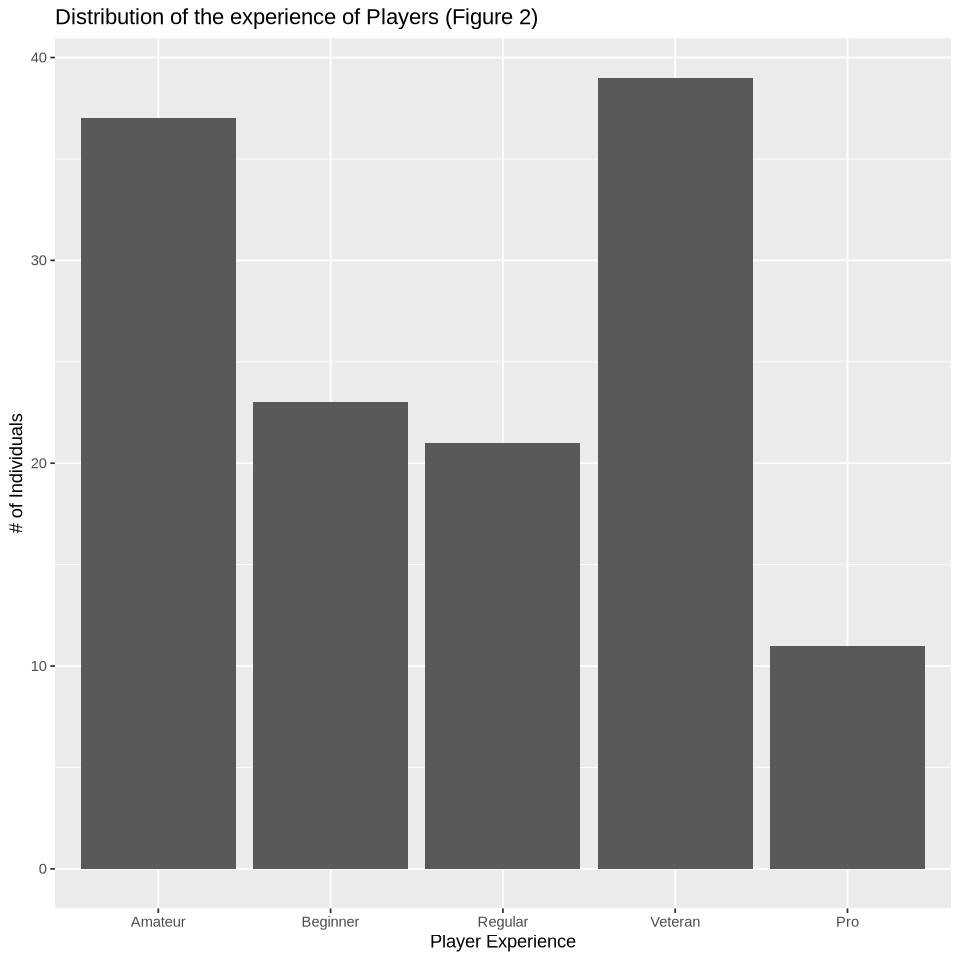

In [8]:
options(repr.plot.width = 8, repr.plot.height = 8)
experience_bar <- train_processed |>
            ggplot(aes(x = experience)) +
            geom_bar() +
            labs(title = "Distribution of the experience of Players (Figure 2)",
                 x = "Player Experience",
                 y = "# of Individuals")
experience_bar

####  Interpretation of Figure 2

Figure 2 illustrates the distribution of players across different experience levels. The largest groups are “Amateur” and “Veteran” indicating that this dataset primarily consists of relatively new and experienced users. In contrast, the “pro” players group is the smallest, suggesting that top-tier players are relatively scarce on this server.

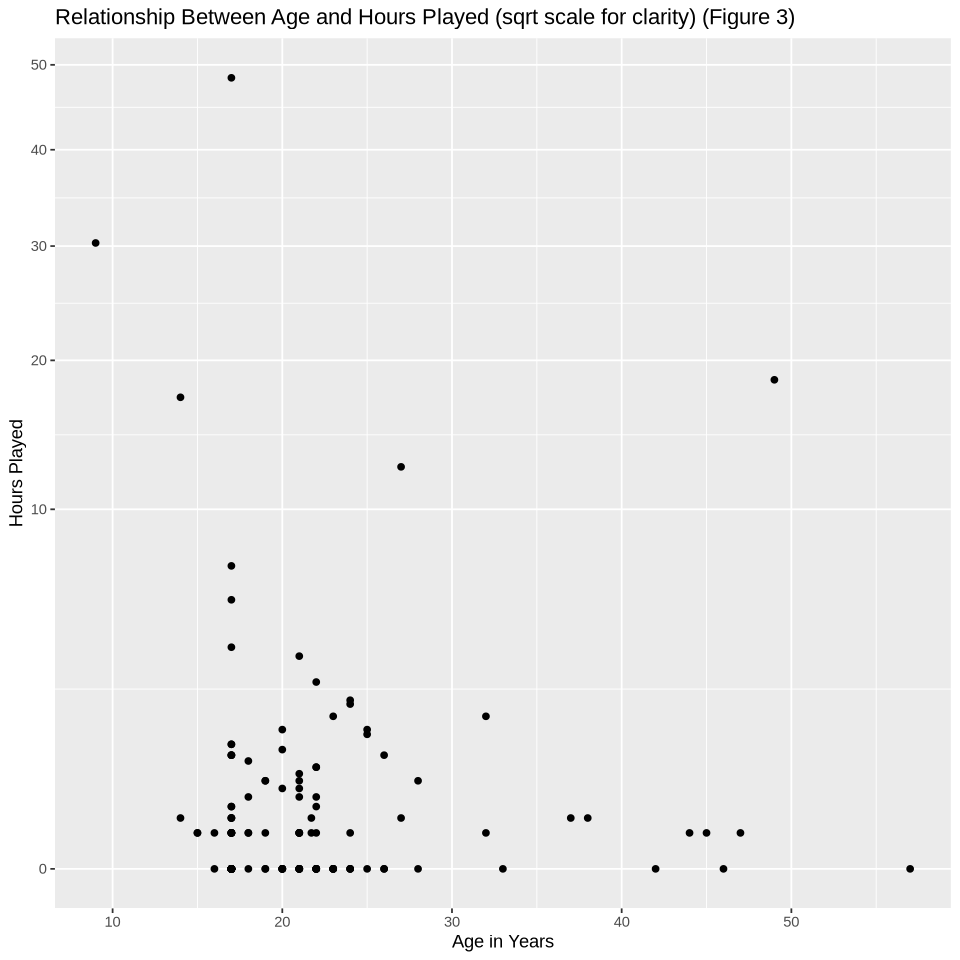

In [9]:
options(repr.plot.width = 8, repr.plot.height = 8)
age_plot <- train_processed |>
            ggplot(aes(x = Age, y = played_hours)) +
            geom_point() +
            scale_y_sqrt() + # using sqrt scale so that the small values are more visible
            labs(title = "Relationship Between Age and Hours Played (sqrt scale for clarity) (Figure 3)",
                 x = "Age in Years",
                 y = "Hours Played")
age_plot

####  Interpretation of Figure 3

Figure 3 visually illustrates the relationship between player age and total gaming duration. Overall, no clear linear correlation exists between these two variables. Players across different age groups predominantly cluster within lower gaming duration ranges. A small minority, particularly those in their teens to early twenties, exhibit exceptionally high gaming durations; however, these appear to be outliers rather than a prevailing trend.

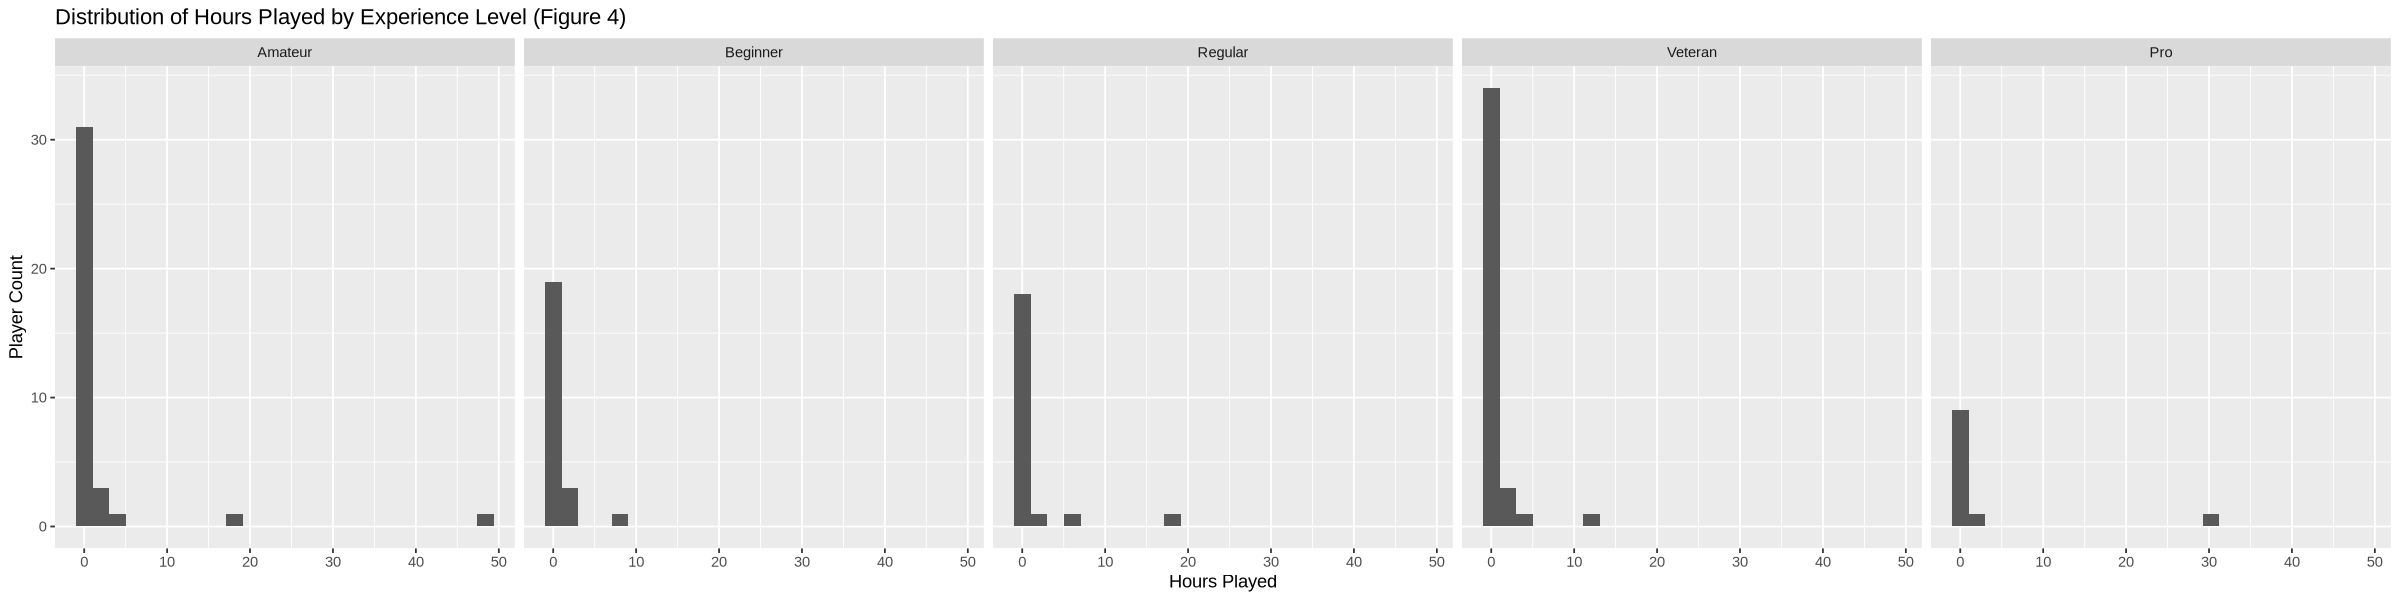

In [10]:
options(repr.plot.width = 20, repr.plot.height = 5)
exp_plot <- train_processed |>
            ggplot(aes(x = played_hours)) + 
            geom_histogram(bins = 25) +
            facet_wrap(~ experience, nrow = 1) +
            labs(title = "Distribution of Hours Played by Experience Level (Figure 4)",
                 x = "Hours Played",
                 y = "Player Count")
exp_plot

####  Interpretation of Figure 4

Figure 4 illustrates the distribution of gameplay duration across different player experience levels. Across all experience categories, the data exhibits a pronounced right-skewed distribution, with the vast majority of players spending between 0 and 10 hours playing. Overall, no clear stepwise increase in total playtime was observed with increasing experience level.

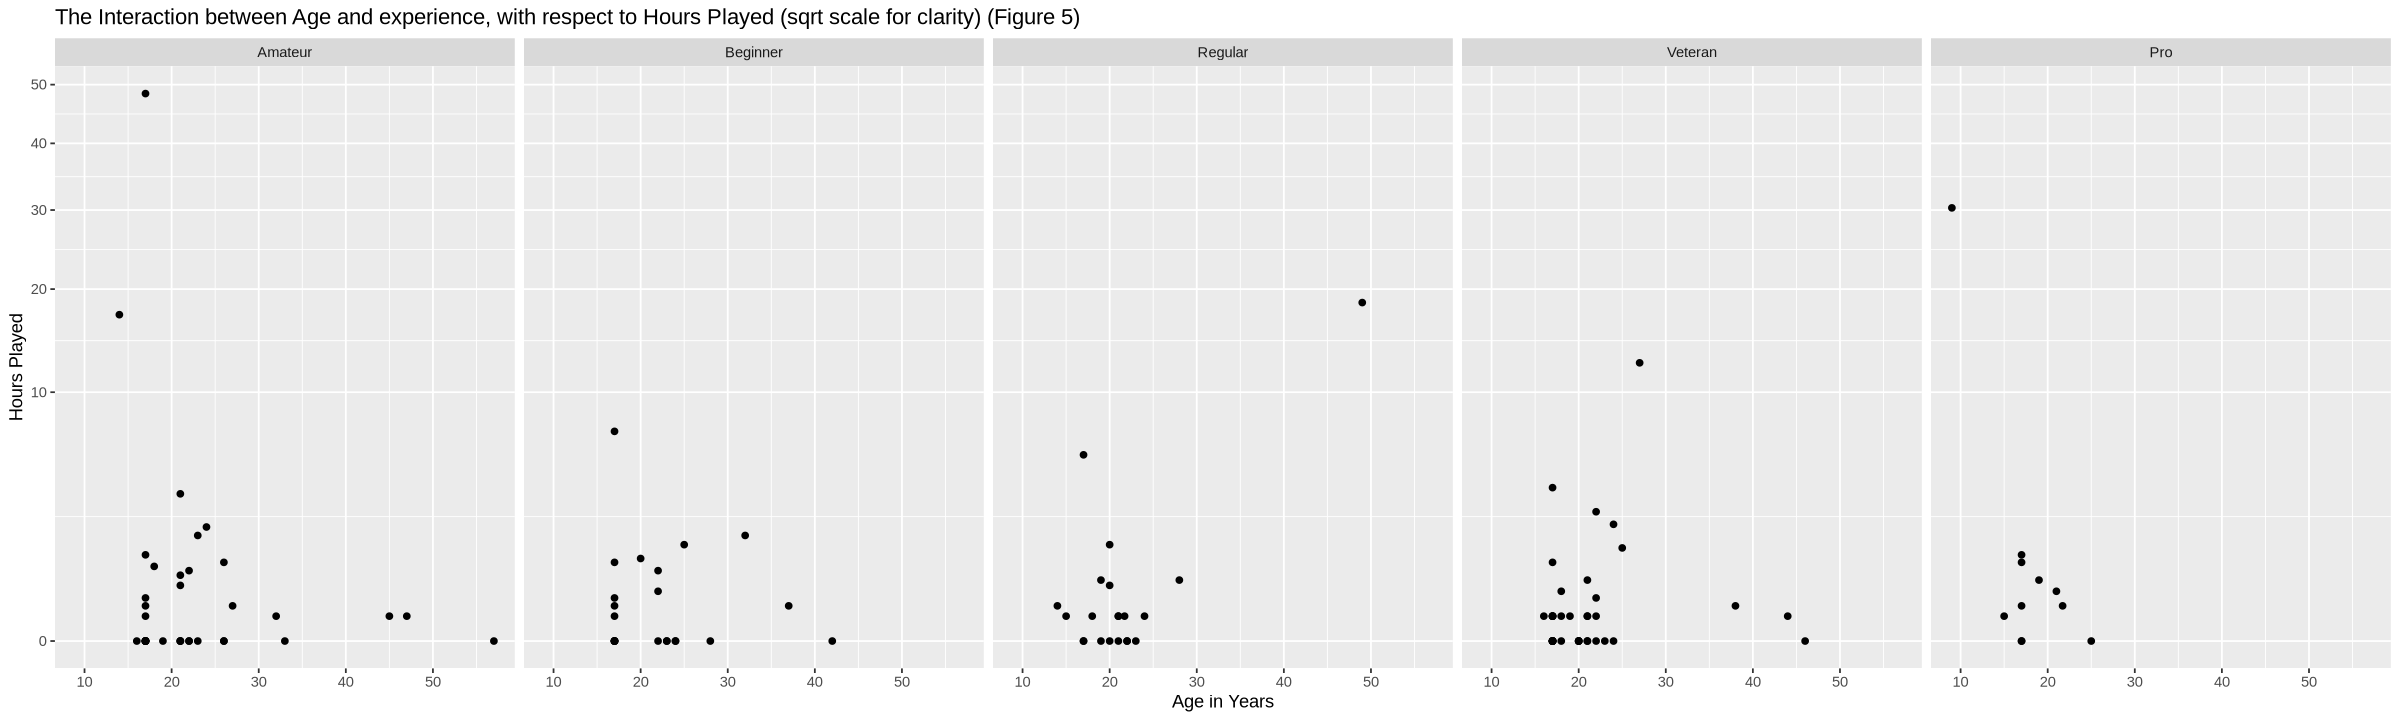

In [11]:
options(repr.plot.width = 20, repr.plot.height = 6)
interaction_plot <- train_processed |>
                    ggplot(aes(x = Age, y = played_hours)) +
                    geom_point() +
                    scale_y_sqrt() + # using sqrt scale so that the small values are more visible
                    facet_wrap(~ experience, nrow = 1) +
                    labs(title = "The Interaction between Age and experience, with respect to Hours Played (sqrt scale for clarity) (Figure 5)",
                         x = "Age in Years",
                         y = "Hours Played")
interaction_plot

####  Interpretation of Figure 5

Figure 5 illustrates the relationship between age and playtime across different experience levels. Overall, data points are highly concentrated in the 10 to 30 year old age range, with the vast majority of points falling within the lower playtime bracket. No significant linear relationship between age and playtime was observed.

### Models:

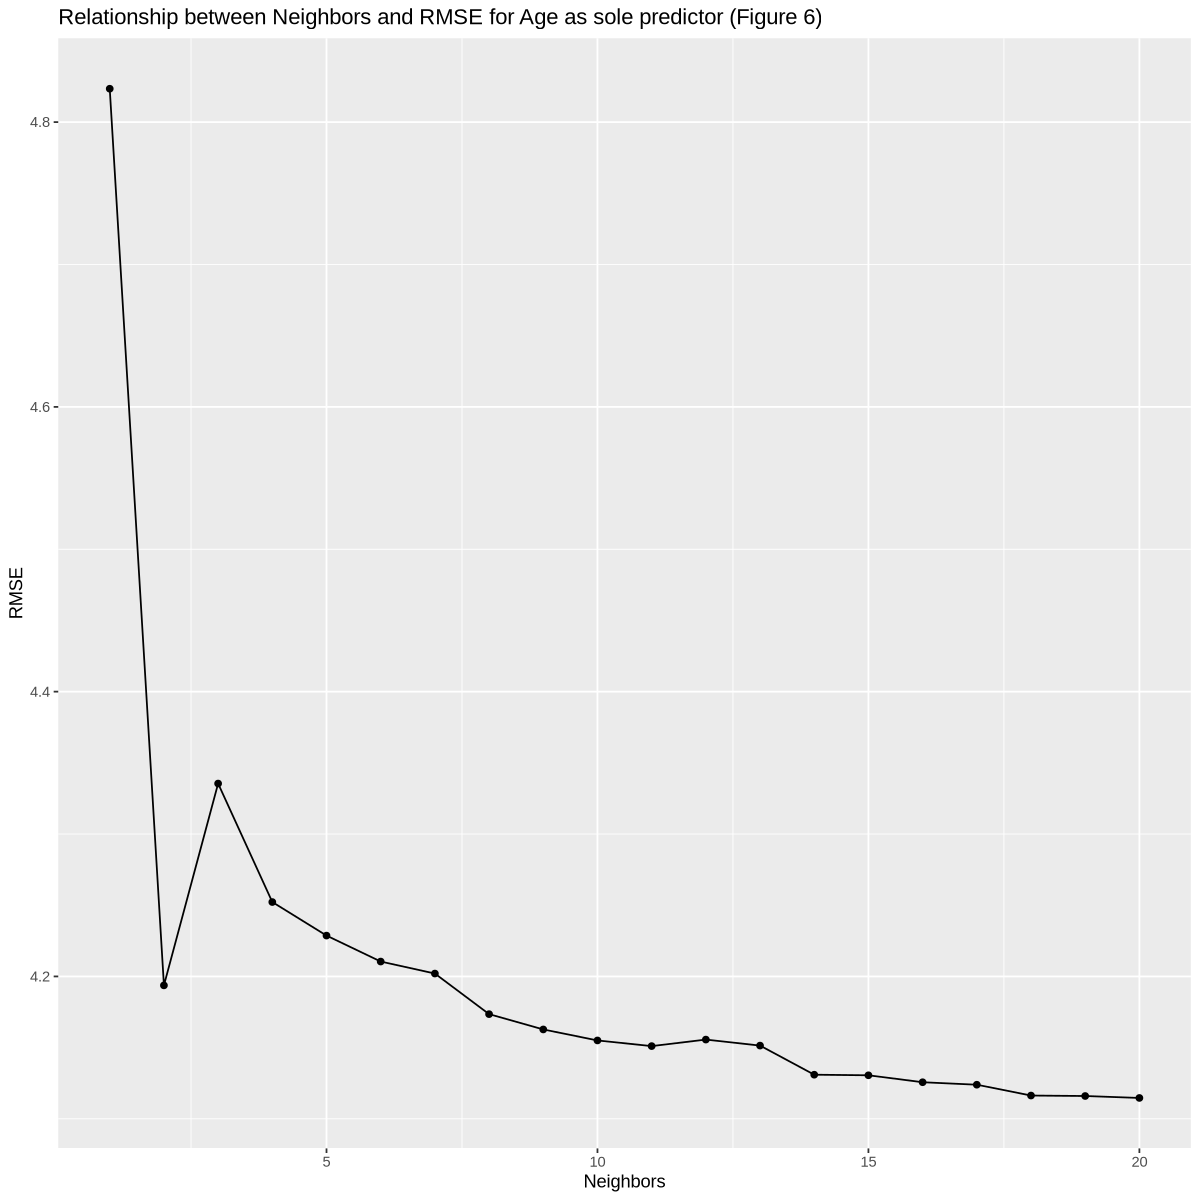

In [13]:
set.seed(42)
# Only using age as a predictor

# Model specification for tuning
age_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

# Model recipe
age_recipe <- recipe(played_hours ~ Age, data = train_processed) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

# Cross validation (10 folds for more reliable RMSE estimates, and seeing as the dataset is small, computation will still be fast)
age_vfold <- vfold_cv(train_processed, v = 10, strata = played_hours)

# Model workflow
age_workflow <- workflow() |> 
                add_recipe(age_recipe) |> 
                add_model(age_spec)

# Testing k from 1-20
gridvals <- tibble(neighbors = seq(1, 20, by=1))

age_results <- age_workflow |> 
               tune_grid(resamples = age_vfold, grid = gridvals) |> 
               collect_metrics() |>
               filter(.metric == "rmse")

options(repr.plot.width = 10, repr.plot.height = 10)
age_results_plot <- age_results |>
                    ggplot(aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Neighbors", y = "RMSE", title = "Relationship between Neighbors and RMSE for Age as sole predictor (Figure 6)")
age_results_plot

In [14]:
# Taking the "elbow" of figure 6 so that we can avoid overfitting. Would normally take the k that results in min rmse, but rmse keeps decreasing as k increases.
age_k <- 2

# Tuned model specification
age_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = age_k) |>
         set_engine("kknn") |>
         set_mode("regression")

age_best_fit <- workflow() |>
         add_recipe(age_recipe) |>
         add_model(age_best_spec) |>
         fit(data = train_processed)

age_summary <- age_best_fit |>
          predict(test_processed) |>
          bind_cols(test_processed) |>
          metrics(truth = played_hours, estimate = .pred)

# Model scores
age_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,6.722965321
rsq,standard,0.002924174
mae,standard,2.505932203


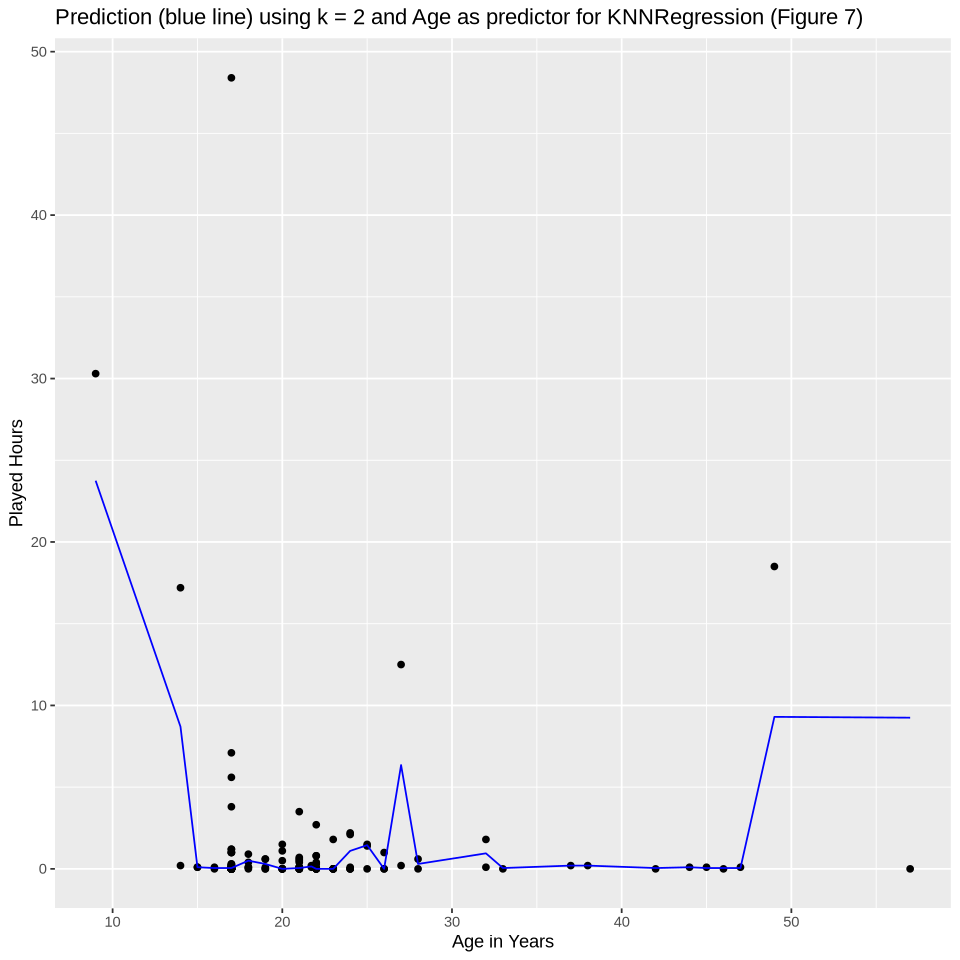

In [16]:
set.seed(42)
options(repr.plot.width = 8, repr.plot.height = 8)

# Prediction plot
age_preds <- age_best_fit |> 
            predict(train_processed) |> 
            bind_cols(train_processed) |>
            arrange(Age)
age_plot <- ggplot(age_preds, aes(x = Age, y = played_hours)) +
                    geom_point() +
                    geom_line(data = age_preds,
                             mapping = aes(y = .pred),
                             color = "blue") +
                    labs(x = "Age in Years", y = "Played Hours", title = "Prediction (blue line) using k = 2 and Age as predictor for KNNRegression (Figure 7)")
age_plot

→ A | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned.

There were issues with some computations   A: x1

There were issues with some computations   A: x2





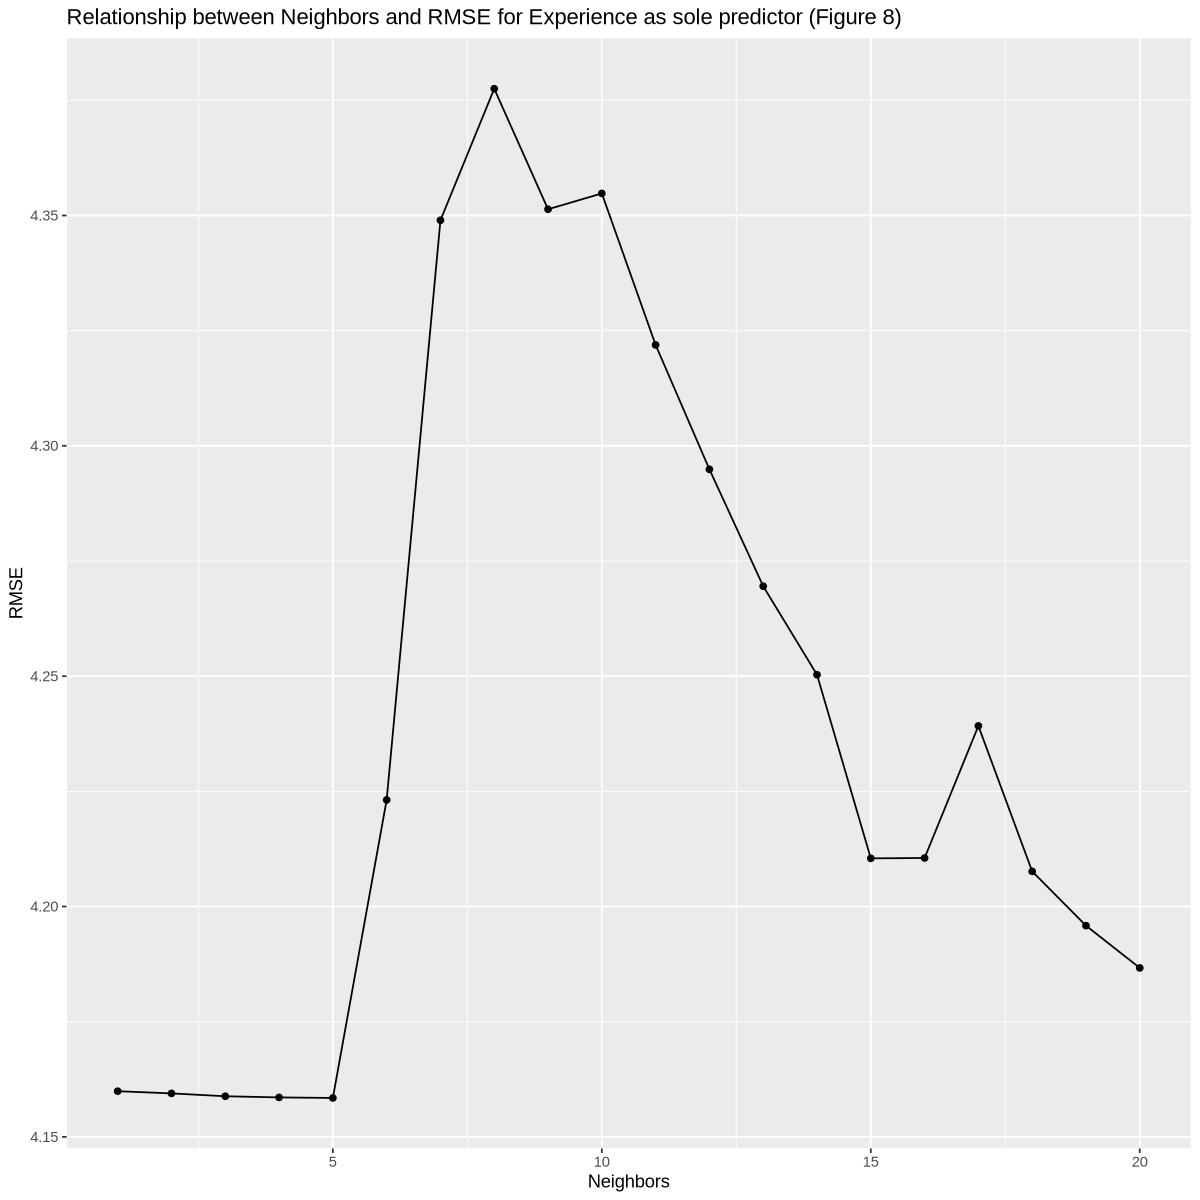

In [17]:
set.seed(42)
# Only using experience as a predictor
# Ignore the warning produced, this is just because the prediction is constant and the std is 0

# Model specification for tuning
exp_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

# Model recipe
exp_recipe <- recipe(played_hours ~ experience_int, data = train_processed) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

# Cross validation (10 folds for more reliable RMSE estimates, and seeing as the dataset is small, computation will still be fast)
exp_vfold <- vfold_cv(train_processed, v = 10, strata = played_hours)

# Model workflow
exp_workflow <- workflow() |>
                add_recipe(exp_recipe) |>
                add_model(exp_spec)

# Testing k from 1-20
gridvals <- tibble(neighbors = seq(1, 20, by=1))

exp_results <- exp_workflow |> 
               tune_grid(resamples = exp_vfold, grid = gridvals) |> 
               collect_metrics() |>
               filter(.metric == "rmse")

options(repr.plot.width = 10, repr.plot.height = 10)
exp_results_plot <- exp_results |>
                    ggplot(aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Neighbors", y = "RMSE", title = "Relationship between Neighbors and RMSE for Experience as sole predictor (Figure 8)")

# Plot looks a little jagged and less "elbow-curve like" due to the discrete and ordinal predictor (experience_int) combined with the way knn works
exp_results_plot

In [18]:
# Taking the initial lowest rmse, because with the trend of the curve, it looks like as k increases, rmse will also decrease. Seeing as the dataset is zero-heavy, a super high k is not as insightful.
exp_k <- 5

# Tuned model specification
exp_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = exp_k) |>
         set_engine("kknn") |>
         set_mode("regression")

exp_best_fit <- workflow() |>
         add_recipe(exp_recipe) |>
         add_model(exp_best_spec) |>
         fit(data = train_processed)

exp_summary <- exp_best_fit |>
          predict(test_processed) |>
          bind_cols(test_processed) |>
          metrics(truth = played_hours, estimate = .pred)

# Model scores
exp_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,5.278716459
rsq,standard,0.009307605
mae,standard,1.424745763


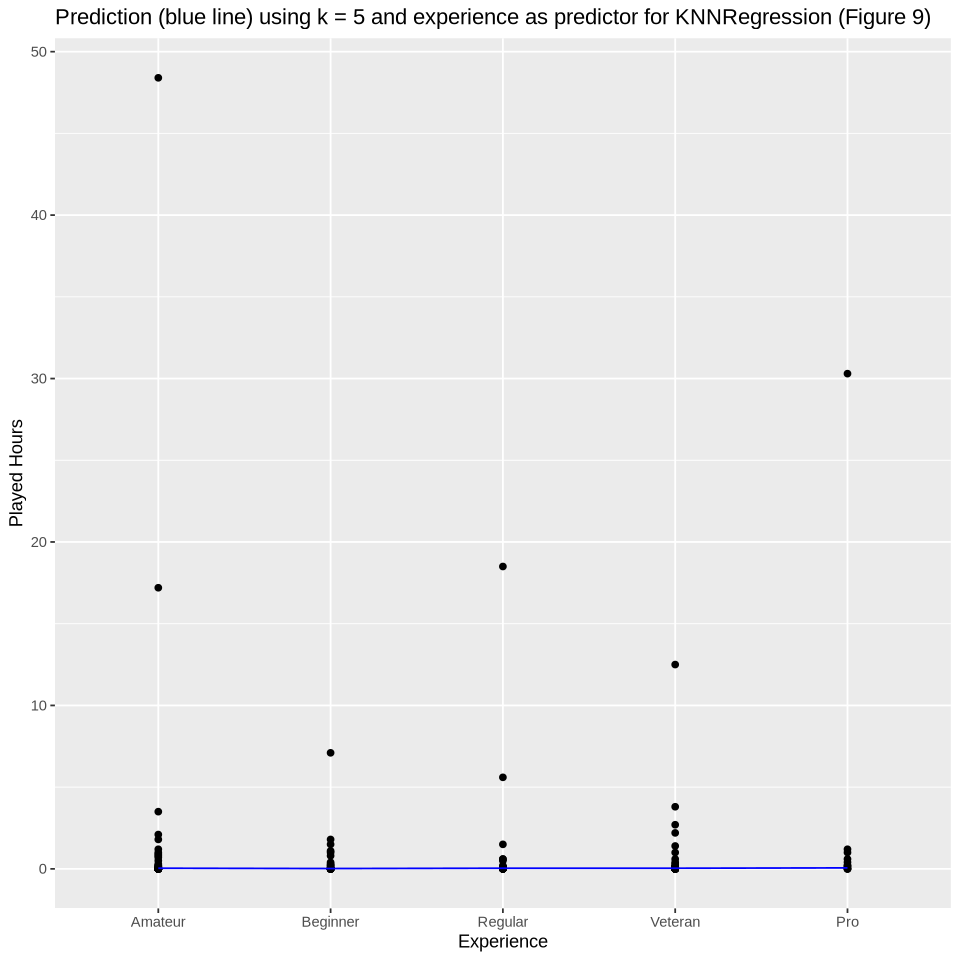

In [19]:
set.seed(42)
options(repr.plot.width = 8, repr.plot.height = 8)

# Prediction plot
exp_preds <- exp_best_fit |> 
             predict(train_processed) |> 
             bind_cols(train_processed) |>
             arrange(experience_int)
exp_plot <- ggplot(exp_preds, aes(x = experience, y = played_hours)) +
                    geom_point() +
                    geom_line(data = exp_preds,
                             mapping = aes(x = experience_int, y = .pred),
                             color = "blue") +
                    labs(x = "Experience", y = "Played Hours", title = "Prediction (blue line) using k = 5 and experience as predictor for KNNRegression (Figure 9)")
exp_plot

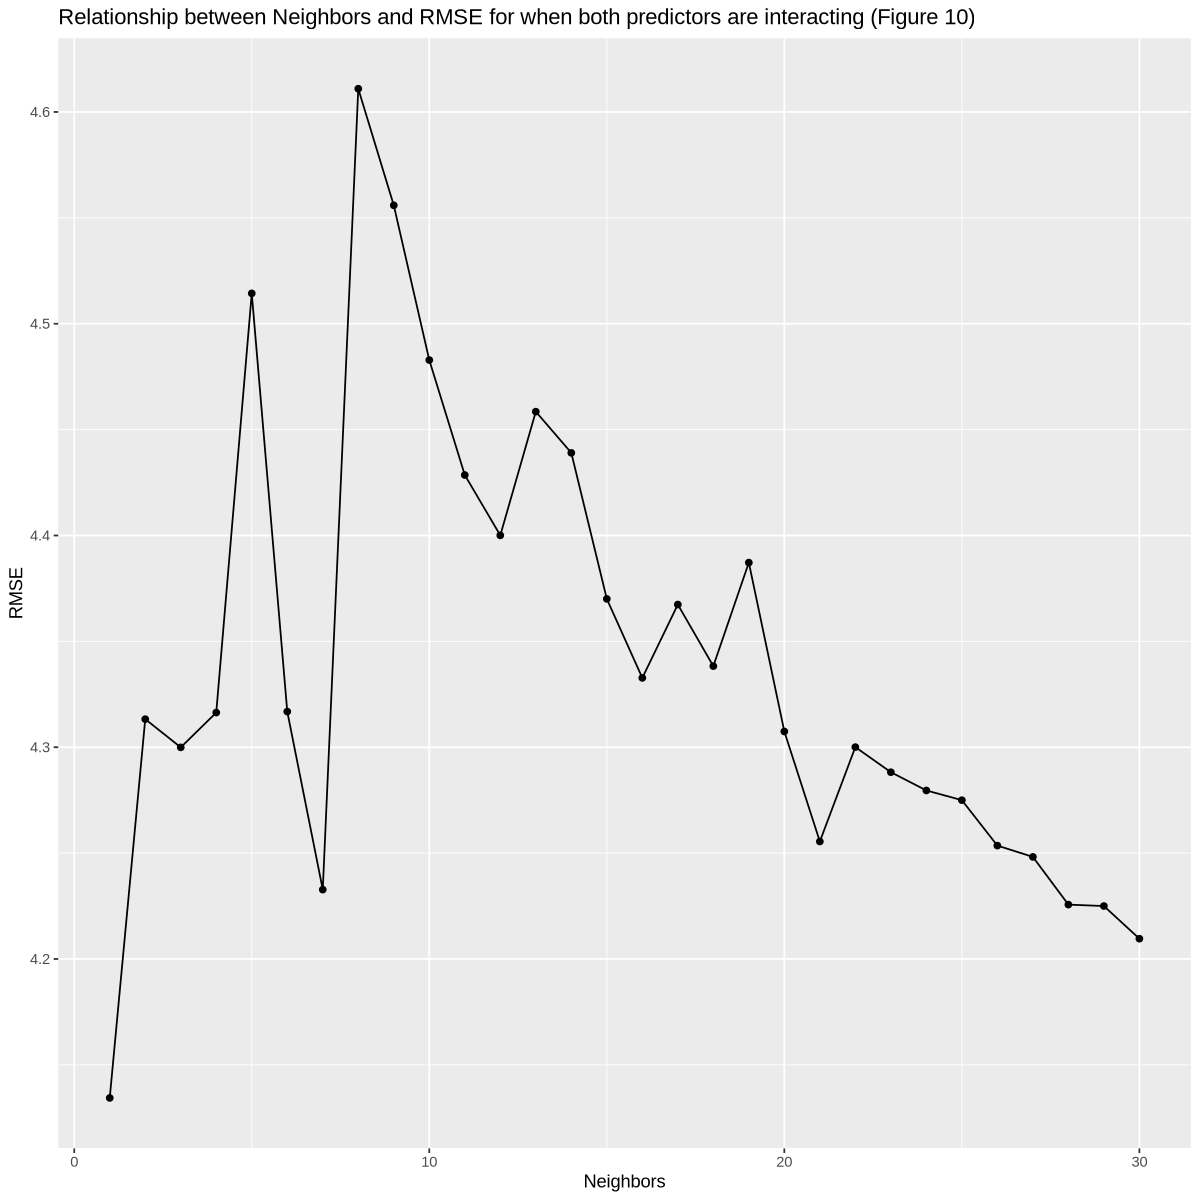

In [20]:
set.seed(42)
# Using both Age and experience as predictors

# Model specification for tuning
interact_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

# Model recipe
interact_recipe <- recipe(played_hours ~ Age + experience_int, data = train_processed) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

# Cross validation (10 folds for more reliable RMSE estimates, and seeing as the dataset is small, computation will still be fast)
interact_vfold <- vfold_cv(train_processed, v = 10, strata = played_hours)

# Model workflow
interact_workflow <- workflow() |>
                     add_recipe(interact_recipe) |>
                     add_model(interact_spec)

# Testing k from 1-30
gridvals <- tibble(neighbors = seq(1, 30, by=1))

interact_results <- interact_workflow |> 
               tune_grid(resamples = interact_vfold, grid = gridvals) |> 
               collect_metrics() |>
               filter(.metric == "rmse")

options(repr.plot.width = 10, repr.plot.height = 10)
interact_results_plot <- interact_results |>
                    ggplot(aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Neighbors", y = "RMSE", title = "Relationship between Neighbors and RMSE for when both predictors are interacting (Figure 10)")

# Plot looks a little jagged and less "elbow-curve like" due to the inclusion of the discrete and ordinal predictor (experience_int) combined with the way knn works
interact_results_plot

In [21]:
# Taking the initial lowest rmse (excluding k = 1 because that is not helpful), because with the trend of the curve, it looks like as k increases, rmse will also decrease. Seeing as the dataset is zero-heavy, a super high k is not as insightful.
interact_k <- 7

# Tuned model specification
interact_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = interact_k) |>
         set_engine("kknn") |>
         set_mode("regression")

interact_best_fit <- workflow() |>
         add_recipe(interact_recipe) |>
         add_model(interact_best_spec) |>
         fit(data = train_processed)

interact_summary <- interact_best_fit |>
          predict(test_processed) |>
          bind_cols(test_processed) |>
          metrics(truth = played_hours, estimate = .pred)

# Model scores
interact_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,5.263281696
rsq,standard,0.001402274
mae,standard,1.614285714


## Discussion:

### Findings:
- We found minimal correlations between either age or experience with regard to playtime. Namely, the data being so heavily skewed towards a) players with zero recorded hours of playtime and b) players approximately of ages 10-30 makes it difficult to predict much of anything. In other words, it's difficult to analyse data around age and playtime when over half of the players are ages 17-22 and the median recorded playtime is 0.10 hours.

### Expectations vs. Reality:
- Due to pre-analysis done in our individual portions of the project, we suspected that player experience on its own would make for a poor predictor. However, we hoped that player age might be a more fruitful angle of analysis, with the hypothesis that younger players would have more available time due to fewer obligations, and thus be able to provide more data. We also hoped that age and experience combined would be able to produce interesting results.
- However, we found that ultimately the data was skewed such that it was difficult to get much of any useful predictions from these variables.

### Impact of our Findings:
- These findings show that, at least in the player data provided to us here, neither player age nor player experience make for useful predictors of playtime. Should the PLAICraft team wish to work on their recruitment efforts and find more players that give useful data, then they should be looking at other predictors, or possibly trying to reach out to entirely different player populations altogether.

### Future Questions:
- Regarding the player data currently available, future questions might include whether playtime is influenced by either player gender or play subscription status to the PLAICraft newsletter.

## References (Optional)